In [ ]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

from data_preprocessing_utils import data_for_training
from utils import compute_error

from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
import pandas as pd
import numpy as np

## load and aggregate data by month

In [7]:
sales_and_purchase_prices=pd.read_csv('../data/prepocessing/sales_and_purchase_prices.csv')


# Removal of some columns that are not important for prediction: ["InventoryId","Brand","Volume","VendorNo","Amount","VendorName"]
sales_and_purchase_prices=sales_and_purchase_prices.drop(["InventoryId","Brand","Volume","VendorNo","Amount","VendorName","SalesDollars"], axis=1)


# Convert date columns to datetime format
sales_and_purchase_prices['SalesDate'] = pd.to_datetime(sales_and_purchase_prices['SalesDate'])

# Créez une nouvelle colonne pour l'année et le mois
sales_and_purchase_prices['Year'] = sales_and_purchase_prices['SalesDate'].dt.year
sales_and_purchase_prices['Month'] = sales_and_purchase_prices['SalesDate'].dt.month

# Groupez les données par année et par mois et calculez les agrégats souhaités pour chaque groupe
sales_month_aggregated=sales_and_purchase_prices.groupby(['Year', 'Month','Description','Store','Classification']).agg({
    'SalesQuantity': 'sum',
    'ExciseTax': 'first',
    'Size': 'mean',
    'PurchasePrice': 'first',
    'SalesPrice':'first',

    # Ajoutez d'autres colonnes que vous souhaitez agréger ici
}).reset_index()

sales_month_aggregated.head()

,Year,Month,Description,Store,Classification,SalesQuantity,ExciseTax,Size,PurchasePrice,SalesPrice
0,2016,1,(RI) 1,1,1,1,0.79,750.0,26.92,36.99
1,2016,1,(RI) 1,22,1,1,0.79,750.0,26.92,36.99
2,2016,1,(RI) 1,33,1,1,0.79,750.0,26.92,36.99
3,2016,1,(RI) 1,34,1,3,0.79,750.0,26.92,36.99
4,2016,1,(RI) 1,35,1,1,0.79,750.0,26.92,36.99


## Load the optimized model, make predictions on the test data and calculate the errors. You can then compare performance with other models, such as the reference models created previously.

In [16]:

_,X_test,_,_,y_test,_=data_for_training(sales_month_aggregated)

hidden_layer_one=50
hidden_layer_two=100
dropout_one=0
dropout_two=0


model=get_mlp_model(input_shape=(X_test.shape[1],),hidden_layer_one=hidden_layer_one,dropout_one=dropout_one,hidden_layer_two=hidden_layer_two,dropout_two=dropout_two)


checkpoint_filepath = '../checkpoint/base_model_checkpoint.h5'

# Load the best weights from the saved checkpoint
model.load_weights(checkpoint_filepath)

# Evaluate the performance of the model on the test set
y_test_pred = model.predict(X_test)

# Calculate performance metrics
rmse2, corr2, mae2, rae2, rrse2, mape2, r2_2 = compute_error(y_test.values, y_test_pred.reshape(y_test_pred.shape[0]))
print("RMSE:", rmse2)
print("Corrélation:", corr2)
print("MAE:", mae2)
print("RAE:", rae2)
print("RRSE:", rrse2)
print("MAPE:", mape2)
print("R2:", r2_2)
print("----------------------------------")



660/660 [==============================] - 1s 2ms/step
RMSE: 16.28005789836581
Corrélation: 0.9130218243832023
MAE: 7.060958125723754
RAE: 0.3972099571373407
RRSE: 0.4094444879797033
MAPE: 94.34587694413685
R2: 0.8323552112630386
----------------------------------


**Performance comparaison**

In [ ]:
from prettytable import PrettyTable

# Créer une instance de PrettyTable et définir les en-têtes
table = PrettyTable()
table.field_names = ["Model", "RMSE", "Correlation", "MAE", "RAE", "RRSE", "MAPE", "R2"]

# Ajouter les données des mesures de performance
table.add_row(["Random Forest", 23.3435, 0.812994, 8.96228, 0.504168, 0.58709, 82.339, 0.655325])
table.add_row(["Linear Regression", 23.8307, 0.802579, 11.2327, 0.631891, 0.599343, 218.499, 0.640788])
table.add_row(["Lasso", 33.9357, 0.547551, 15.9419, 0.896799, 0.853486, 365.006, 0.271562])
table.add_row(["Ridge", 23.8388, 0.801596, 11.1452, 0.626969, 0.599547, 214.896, 0.640543])
table.add_row(["ElasticNet", 38.4939, 0.251833, 17.1119, 0.962617, 0.968125, 397.283, 0.0627341])
table.add_row(["KNN", 26.1298, 0.765809, 10.7885, 0.606903, 0.657167, 142.926, 0.568132])

# Ajouter Stock Management modèle avec mise en évidence
stock_management_row = ["Stock Management Model", 17.1057, "\033[1;32m0.923358\033[0m", 7.52769, 0.406239, 0.3849, 120.014, "\033[1;32m0.85185\033[0m"]
table.add_row(stock_management_row)

# Personnaliser les couleurs des lignes
table.align = "c"
table.hrules = True
table.horizontal_char = "─"
table.vertical_char = "│"
table.junction_char = "┼"

# Afficher le tableau
print(table)


┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│         Model          │   RMSE  │ Correlation │   MAE   │   RAE    │   RRSE   │   MAPE  │     R2    │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│     Random Forest      │ 23.3435 │   0.812994  │ 8.96228 │ 0.504168 │ 0.58709  │  82.339 │  0.655325 │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│   Linear Regression    │ 23.8307 │   0.802579  │ 11.2327 │ 0.631891 │ 0.599343 │ 218.499 │  0.640788 │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│         Lasso          │ 33.9357 │   0.547551  │ 15.9419 │ 0.896799 │ 0.853486 │ 365.006 │  0.271562 │
┼────────────────────────┼─────────┼─────────────┼─────────┼──────────┼──────────┼─────────┼───────────┼
│         Ridge          │ 23.8388 │   0.801596  │ 11.1

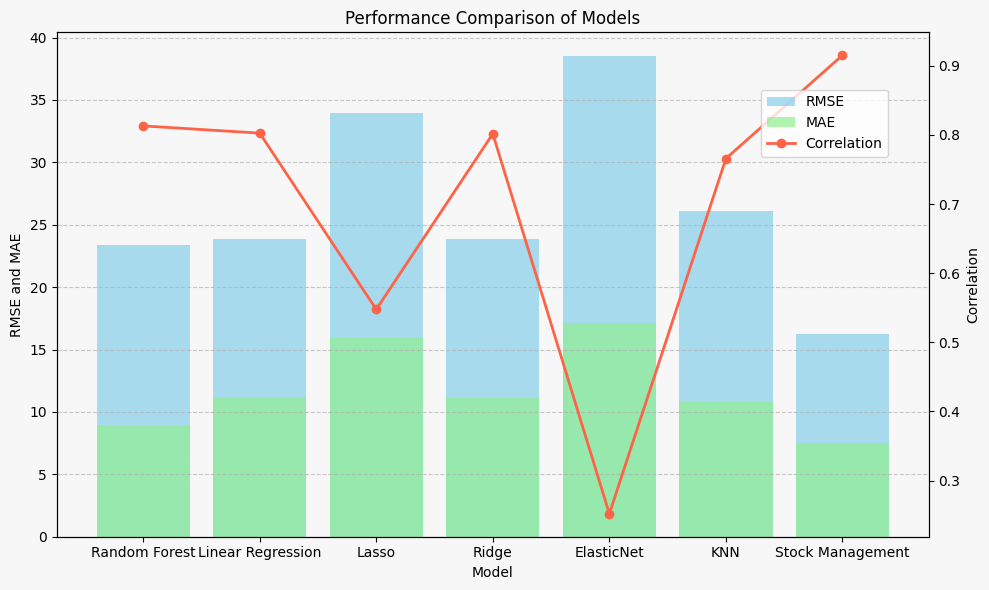

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Données des mesures de performance
models = ['Random Forest', 'Linear Regression', 'Lasso', 'Ridge', 'ElasticNet', 'KNN', 'Stock Management']
rmse = [23.3435, 23.8307, 33.9357, 23.8388, 38.4939, 26.1298, 16.2239]
correlation = [0.812994, 0.802579, 0.547551, 0.801596, 0.251833, 0.765809, 0.915217]
mae = [8.96228, 11.2327, 15.9419, 11.1452, 17.1119, 10.7885, 7.52769]



# Créer la figure et les axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Barres pour le RMSE et le MAE
ax1.bar(models, rmse, color='skyblue', alpha=0.7, label='RMSE')
ax1.bar(models, mae, color='lightgreen', alpha=0.7, label='MAE')

# Créer un axe pour la corrélation
ax2 = ax1.twinx()
ax2.plot(models, correlation, color='tomato', marker='o', label='Correlation', linewidth=2)

# Personnalisation des axes
ax1.set_xlabel('Model')
ax1.set_ylabel('RMSE and MAE', color='black')
ax2.set_ylabel('Correlation', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='black')

# Ajouter une grille pour améliorer la lisibilité
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Légende
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left', bbox_to_anchor=(0.8, 0.9))

# Titre et ajustements
plt.title('Performance Comparison of Models')
plt.tight_layout()

# Ajouter un fond coloré pour un aspect plus attrayant
ax1.set_facecolor('#f7f7f7')
fig.patch.set_facecolor('#f7f7f7')

# Afficher la figure
plt.show()
